# Credit Card Fraud

This dataset consists of credit card transactions in the western United States. It includes information about each transaction including customer details, the merchant and category of purchase, and whether or not the transaction was a fraud.

[Source](https://www.kaggle.com/kartik2112/fraud-detection?select=fraudTrain.csv) of dataset

In [32]:
# Import relevant libraries
import pandas as pd 
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Statistics and machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score


In [14]:
# Load data
ccf = pd.read_csv('credit_card_fraud.csv',parse_dates=['trans_date_trans_time']) 
ccf.head(100)

ccf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339607 entries, 0 to 339606
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  339607 non-null  datetime64[ns]
 1   merchant               339607 non-null  object        
 2   category               339607 non-null  object        
 3   amt                    339607 non-null  float64       
 4   city                   339607 non-null  object        
 5   state                  339607 non-null  object        
 6   lat                    339607 non-null  float64       
 7   long                   339607 non-null  float64       
 8   city_pop               339607 non-null  int64         
 9   job                    339607 non-null  object        
 10  dob                    339607 non-null  object        
 11  trans_num              339607 non-null  object        
 12  merch_lat              339607 non-null  floa

## Data Dictionary

| transdatetrans_time | Transaction DateTime                        |
|---------------------|---------------------------------------------|
| merchant            | Merchant Name                               |
| category            | Category of Merchant                        |
| amt                 | Amount of Transaction                       |
| city                | City of Credit Card Holder                  |
| state               | State of Credit Card Holder                 |
| lat                 | Latitude Location of Purchase               |
| long                | Longitude Location of Purchase              |
| city_pop            | Credit Card Holder's City Population        |
| job                 | Job of Credit Card Holder                   |
| dob                 | Date of Birth of Credit Card Holder         |
| trans_num           | Transaction Number                          |
| merch_lat           | Latitude Location of Merchant               |
| merch_long          | Longitude Location of Merchant              |
| is_fraud            | Whether Transaction is Fraud (1) or Not (0) |

There does not seem to be any evidence of missing data points. However, it is possible that the missing values are 

# Data Exploration

'Fraud comprises  0.5% of all transactions'

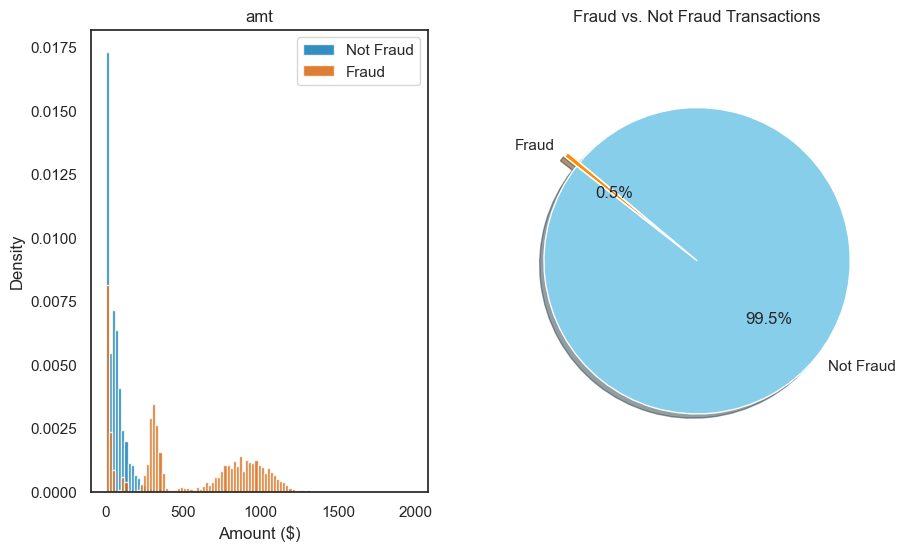

In [15]:
# The data set is massive and fraud should be relatively sparse. In order to get a better sense of what the data look like without imposing the computational load of interacting with 300K+ data points, we will sample the non-fraudulent data set such that so we have the same number of data points as the fraudulent transactions.

# Note that fraud makes up a tiny percentage of the overall data set
percent_fraud = np.round(ccf['is_fraud'].mean()*100,2)
display(f"Fraud comprises {percent_fraud: .1f}% of all transactions")
# Split the fraud and non-fraud datsets
ccf_fraud = ccf[ccf['is_fraud']==1]
ccf_true = ccf[ccf['is_fraud']==0]
ccf_true_smallsample = ccf_true.sample(len(ccf_fraud),random_state=21)
# Make the histogram
bins = np.arange(0,2000,20)
fig, (ax,ax2) = plt.subplots(1,2,figsize=(10,6))

# Use a colorblind-friendly palette
colors = ["#0072B2", "#D55E00"]  # Blue, Orange (colorblind-friendly)

nonfraudcolor = colors[0]
fraudcolor = colors[1]
# Plotting non-fraudulent transactions
ccf_true_smallsample.hist('amt',
                          bins=bins,
                          ax=ax,
                          alpha=.8,
                          color=nonfraudcolor,
                          density=True,
                          grid=False
                          )
ax.set_title('Transaction Amount Distribution')  # Set title for the histogram
ax.set_xlabel('Amount ($)')  # Set X-label for the histogram
ax.set_ylabel('Density')  # Set Y-label for the histogram
ax.legend(["Not Fraud"])
# Plotting fraudulent transactions
ccf_fraud.hist('amt',
               bins=bins,
               ax=ax,
               alpha=.8,
               color=fraudcolor,
               density=True,
               grid=False
               )

ax.legend(["Not Fraud","Fraud"])


# Pie chart of fraud
fraud_count = ccf['is_fraud'].sum()
non_fraud_count = len(ccf) - fraud_count

# Data to plot
labels = 'Fraud', 'Not Fraud'
sizes = [fraud_count, non_fraud_count]
colors = ['darkorange', 'skyblue']
explode = (0.1, 0)  # explode the first slice (fraud)

# Plot pie
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Fraud vs. Not Fraud Transactions')
plt.show()

Fraud is spread out throught the range of potential transaction amounts ($). In addition, it is relatively rare. Presumably, other features (such as the location of the transaction compared to the location of the merchant) may provide more explanatory power, but we will most likely need to start with a model that can handle imbalanced data well. Let's next make column of the distance between the location of the merchant and the location of the purchase and try to see if there are any obvious trends. We will generate the latitude and longitude and then simply calculate the hypotenuse to determine the distance. This may be useful for our model anyway.

# Calculating Merchant-Purchaser Distance 

(0.0, 30396.345)

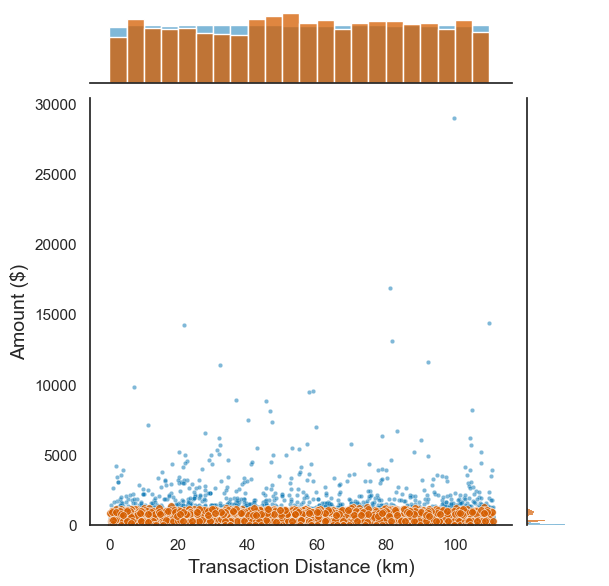

In [29]:
# 40,075 km / 360 degrees = 111 km per degree of latitude
ccf['lat_diff'] = (ccf['lat'] - ccf['merch_lat']) * 111
# Longitude – conversion to radians and determine the distance based on where you are on earth
# Note that at the equator, 1 degree = 111 km, same as latitude. However, as you move towards the poles this gets shorter. This latitude difference can be adjusted for in the longitude calculation 
ccf['lon_diff'] = (ccf['long'] - ccf['merch_long']) * np.deg2rad(1) * 111 * np.cos(np.deg2rad(ccf['merch_lat']))
# Calculate hypotenuse
ccf['transaction_distance'] = np.sqrt(ccf['lat_diff'] ** 2 + ccf['lon_diff'] ** 2)
# Stratified sampling to look at representative subset of data.
num_samples = 339000
fraud_samples = int(num_samples * percent_fraud/100)
nonfraud_samples = num_samples - fraud_samples
# Separate fraud and non-fraud
fraud_sample = ccf[ccf['is_fraud']==1].sample(n=fraud_samples,random_state=21)
nonfraud_sample = ccf[ccf['is_fraud']==0].sample(n=nonfraud_samples,random_state=21)
# Concatenate fraud and non-fraud samples
ccf_sample = pd.concat([fraud_sample,nonfraud_sample])

sns.set_context('notebook')
sns.set_style('white')
g = sns.JointGrid(data=ccf_sample,x='transaction_distance',y='amt',hue='is_fraud',)

# Plot non-fraudulent transactions first with smaller points and lower alpha
sns.scatterplot(data=ccf_sample[ccf_sample['is_fraud'] == 0], x='transaction_distance', y='amt',
                ax=g.ax_joint, color=nonfraudcolor, alpha=0.5, s=10)

# Overlay with fraudulent transactions with larger points and higher alpha for better visibility
sns.scatterplot(data=ccf_sample[ccf_sample['is_fraud'] == 1], x='transaction_distance', y='amt',
                ax=g.ax_joint, color=fraudcolor, alpha=0.8, s=30)

dist_binsize = 5 # in km
# Plot histograms with density on the margins for non-fraudulent transactions
sns.histplot(data=ccf_sample[ccf_sample['is_fraud'] == 0], 
             x='transaction_distance', 
             ax=g.ax_marg_x,
             stat='density', 
             color=nonfraudcolor, alpha=0.5,
             bins = np.arange(0,ccf_sample[ccf_sample['is_fraud'] == 0]['transaction_distance'].max(),dist_binsize))
sns.histplot(data=ccf_sample[ccf_sample['is_fraud'] == 0], y='amt', 
             ax=g.ax_marg_y, 
             stat='density', 
             color=nonfraudcolor, alpha=0.5, 
             bins = np.arange(0,ccf_sample[ccf_sample['is_fraud'] == 0]['amt'].max(),50))

# Overlay with histograms with density on the margins for fraudulent transactions
sns.histplot(data=ccf_sample[ccf_sample['is_fraud'] == 1], x='transaction_distance',
             ax=g.ax_marg_x,
             stat='density', 
             color=fraudcolor, alpha=0.75,
             bins = np.arange(0,ccf_sample[ccf_sample['is_fraud'] == 1]['transaction_distance'].max(),dist_binsize))
sns.histplot(data=ccf_sample[ccf_sample['is_fraud'] == 1], y='amt', 
             ax=g.ax_marg_y, 
             stat='density', 
             color=fraudcolor, alpha=0.75,
             bins = np.arange(0,ccf_sample[ccf_sample['is_fraud'] == 1]['amt'].max(),50))
g.set_axis_labels(ylabel='Amount ($)',xlabel='Transaction Distance (km)',fontsize = 14)
g.ax_joint.set_ylim(0,)

There seems to be no simple relationship between amount and the distance between merchant and transaction source. This is not surprising in the new global order with online shopping. Casting a wider net, next we will try some machine learning approaches which will help us determine which features of the dataset have the greatest potential for detecting fraudulent transactions.

Before moving on to more complicated models, we will first try Lasso regression. This should help us narrow down which features are most likely to have a significant impact on the prediction. This is particularly important when working with large data sets. After all, computational load will become an issue at some point.

# Data Preprocessing & One-Hot Encoding

In [30]:
# First prepare the data for regression analysis
# Convert 'trans_date_trans_time' and 'dob' to datetime
ccf_sample['trans_date_trans_time'] = pd.to_datetime(ccf_sample['trans_date_trans_time'])
ccf_sample['dob'] = pd.to_datetime(ccf_sample['dob'])

# Extract date and time features
ccf_sample['trans_hour'] = ccf_sample['trans_date_trans_time'].dt.hour
ccf_sample['trans_day_of_week'] = ccf_sample['trans_date_trans_time'].dt.dayofweek
ccf_sample['age'] = (ccf_sample['trans_date_trans_time'] - ccf_sample['dob']).dt.days // 365

# Select categorical and numerical columns for encoding and scaling
categorical_cols = ['category', 'state']  # Using simple categories for one-hot encoding
drop_cols = ['merchant', 'city', 'job']  # drop columns with too many unique values
numerical_cols = ['amt', 'city_pop', 'lat_diff', 'lon_diff', 'transaction_distance', 'trans_hour', 'trans_day_of_week', 'age']

# We will initially drop high cardinality columns for simplicity
try:
    ccf_sample = ccf_sample.drop(columns=drop_cols)
except:
    print("ccf_sample columns already dropped")

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Separate features and target variable
X = ccf_sample.drop(columns=['is_fraud', 'trans_num', 'trans_date_trans_time', 'dob'])  # Dropping unique identifier and original datetime
y = ccf_sample['is_fraud']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Check the shape of the preprocessed data
display(X_train_preprocessed.shape), display(X_test_preprocessed.shape)


(271200, 35)

(67800, 35)

(None, None)

# Random Forest Classifier
Random Forest is a good choice for this type of problem for a couple of reasons. 

We have imbalanced data due to the relative rarity of fraud. RF can train on rare events for a variety of reasons including its use of bootstrap sampling (such that you can have certain trees with a higher-than-normal proportion of fraud) and the complexity of individual decision trees combined with the "democratic" nature of majority voting/averaging (akin to a concept of spike-triggered averaging in neuroscience). Additionally, RF can capture complex non-linear relationships, partly due to the complexity inherent in many decision trees. Indeed, RF can grow without much restriction. This makes it a good model for this type of analysis, but not when real-time predictions are required, where it can be a bit slow.

In [35]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train_preprocessed, y_train)

# Predict on the testing set
y_pred = rf_classifier.predict(X_test_preprocessed)
y_pred_proba = rf_classifier.predict_proba(X_test_preprocessed)[:, 1]

# Evaluate the model
accuracy = rf_classifier.score(X_test_preprocessed, y_test)
precision, recall, f1_score, _ = classification_report(y_test, y_pred, output_dict=True)['weighted avg'].values()
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Metrics from the model evaluation
metrics = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC Score"],
    "Value": [accuracy, precision, recall, f1_score, roc_auc]
}

# Convert dictionary to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the DataFrame
print(metrics_df)

          Metric     Value
0       Accuracy  0.998304
1      Precision  0.998256
2         Recall  0.998304
3       F1 Score  0.998169
4  ROC-AUC Score  0.979469
